In [1]:
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split

import torchvision
from torchvision.models.video import swin_transformer, Swin3D_B_Weights

In [2]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

In [3]:
dirpath = 'Cardiac-Video-Sequence/' # Change to location of this folder on your device
X = torch.load(dirpath+'X_upscaled_tensor.pt')
Y = torch.load(dirpath+'Y_normal_tensor.pt')

In [4]:
X.shape, Y.shape

(torch.Size([112, 25, 3, 224, 224]), torch.Size([112, 126]))

In [5]:
X = X.permute(0, 2, 1, 3, 4)

In [6]:
X.shape, Y.shape

(torch.Size([112, 3, 25, 224, 224]), torch.Size([112, 126]))

In [7]:
class TOCDataset(Dataset):
    def __init__(self, X, Y):
        """
        X: torch.Tensor of shape (N, 25, 80, 80) - videos
        Y: torch.Tensor of shape (N, 126) - target curves
        """
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        # Desired shape: ([B C T H W]):
        # Shape: (batch_size, 3, 25, 224, 224)
        # Expand to 3 channels by repeating along the channel dimension
        #video = self.X[idx].unsqueeze(0).repeat(3, 1, 1, 1)  
        video = self.X[idx]
        #video = video.unsqueeze(0)
        curve = self.Y[idx]
        return video, curve

In [8]:
# Create dataset and data loader
dataset = TOCDataset(X, Y)
train_size = int(6/7 * len(dataset))
test_size = len(dataset) - train_size
bs = 8

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=bs, shuffle=False)

In [9]:
# Initialize SwinTransformer3D base model
model = swin_transformer.swin3d_b(weights=Swin3D_B_Weights.KINETICS400_V1)  

#patch_size=[2, 4, 4]
#embed_dim=128

#model.patch_embed.__init__(in_channels = 1, patch_size=patch_size, embed_dim=embed_dim)
# = PatchEmbed3d(in_channels = 1, patch_size=patch_size, embed_dim=embed_dim)

model.head = nn.Linear(model.head.in_features, 126)
# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [10]:
"""
# Iterate through model layers and apply Xavier weight initialization where possible
def init_weights(model):
    for m in model.modules():
        if isinstance(m, nn.Linear):
            init.xavier_uniform_(m.weight)
            if m.bias is not None:
                init.zeros_(m.bias)
                
def init_final_layer(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight, gain=2.0)  # Increase gain
        if m.bias is not None:
            torch.nn.init.zeros_(m.bias)

init_weights(model)
model.head[-1].apply(init_final_layer)
"""

'\n# Iterate through model layers and apply Xavier weight initialization where possible\ndef init_weights(model):\n    for m in model.modules():\n        if isinstance(m, nn.Linear):\n            init.xavier_uniform_(m.weight)\n            if m.bias is not None:\n                init.zeros_(m.bias)\n                \ndef init_final_layer(m):\n    if isinstance(m, nn.Linear):\n        torch.nn.init.xavier_uniform_(m.weight, gain=2.0)  # Increase gain\n        if m.bias is not None:\n            torch.nn.init.zeros_(m.bias)\n\ninit_weights(model)\nmodel.head[-1].apply(init_final_layer)\n'

In [11]:
# Loss function, optimizer, scheduler
criterion = nn.MSELoss()  # Use MSELoss for regression

optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=0.01)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min', 
    factor=0.5, 
    patience=5, 
    #verbose=True
)

In [12]:
def regularized_loss(outputs, targets, model):
    # Main task loss
    task_loss = criterion(outputs, targets)
    
    # Add L2 regularization to prevent weight collapse
    l2_lambda = 0.01
    l2_reg = torch.tensor(0., device=device)
    for param in model.parameters():
        l2_reg += torch.norm(param)
    
    return task_loss + l2_lambda * l2_reg


In [ ]:
# Training loop
# Early stopping setup

patience = 5
best_train_loss = float('inf')
patience_counter = 0
best_model_weights = None

num_epochs = 500
for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for videos, curves in train_loader:
        videos, curves = videos.to(device), curves.to(device)

        # Forward pass
        outputs = model(videos)
        loss = criterion(outputs, curves)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        
        # Clip gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
        
        optimizer.step()
        
        # In training loop
        loss = regularized_loss(outputs, curves, model)
        total_loss += loss.item()
    
    avg_train_loss = total_loss / len(train_loader)
    scheduler.step(avg_train_loss)
    
    # Early stopping logic
    if avg_train_loss < best_train_loss:
        best_train_loss = avg_train_loss
        patience_counter = 0
        best_model_weights = model.state_dict()  # Save the best model weights
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping triggered. Validation loss did not improve for {patience} epochs.")
            break

    if epoch % 5 == 0:
        print(f"Epoch {epoch}/{num_epochs} loss: {avg_train_loss: .4f}")
        
if best_model_weights is not None:
    model.load_state_dict(best_model_weights)
    print("Restored the best model weights.")
    

Epoch 0/500 loss:  116.9434
Epoch 5/500 loss:  112.8255
Epoch 10/500 loss:  109.1992


In [11]:
# Save weights as a tensor
torch.save(model.state_dict(), dirpath+'swin3d_weights.pth')

In [14]:
# Use the debugger
debugger = LayerDebugger(model)
debugger.register_hooks()

# Get a batch from your dataloader
batch_videos, batch_targets = next(iter(train_loader))
batch_videos = batch_videos.to(device)

# Analyze the batch
with torch.no_grad():
    _ = debugger.analyze_batch(batch_videos)

# Clean up
debugger.remove_hooks()

NameError: name 'LayerDebugger' is not defined

In [94]:
# Function to plot predicted TOS vs. ground truth labels
def plot_predictions(predictions, ground_truths, num_samples=5):
    num_samples = min(num_samples, len(predictions))
    indices = torch.randint(0, len(predictions), (num_samples,))  # Randomly select samples

    for i, idx in enumerate(indices):
        plt.figure(figsize=(6, 3))
        plt.plot(ground_truths[idx].numpy(), label="True Curve", linestyle='--')
        plt.plot(predictions[idx].numpy(), label="Predicted Curve", linestyle='-')
        plt.title(f"Sample {i + 1}")
        plt.xlabel("Point Index")
        plt.ylabel("Value")
        plt.legend()
        plt.grid(True)
        plt.show()

In [115]:
# Function to evaluate the model on the test set and compute both MSE and R²
def evaluate_model_r2(model, test_loader, device):
    model.eval()  # Set the model to evaluation mode
    total_mse = 0
    predictions = []
    ground_truths = []

    with torch.no_grad():
        for videos, curves in test_loader:
            videos, curves = videos.to(device), curves.to(device)
            
            # Forward pass
            outputs = model(videos)
            
            # Accumulate predictions and ground truth for plotting
            predictions.append(outputs.cpu())
            ground_truths.append(curves.cpu())
            
            # Compute MSE for the batch
            total_mse += nn.MSELoss()(outputs, curves).item()

    # Concatenate predictions and ground truths for plotting
    predictions = torch.cat(predictions, dim=0)
    ground_truths = torch.cat(ground_truths, dim=0)

    # Compute average MSE
    avg_mse = total_mse / len(test_loader)

    # Compute R² score
    r2 = r2_score(ground_truths.numpy(), predictions.numpy())

    return avg_mse, r2, predictions, ground_truths

Test MSE: 2.5321
Test R²: -162993.4072


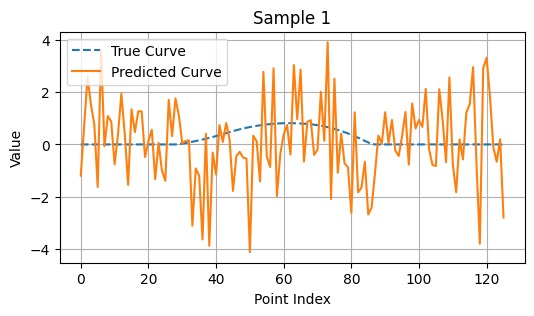

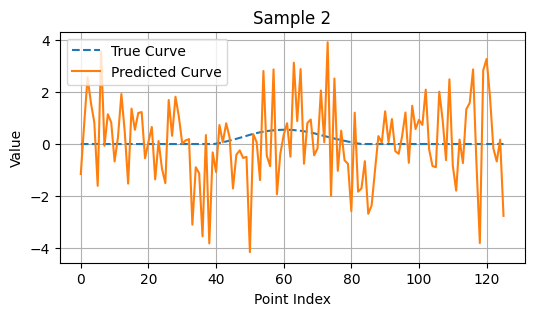

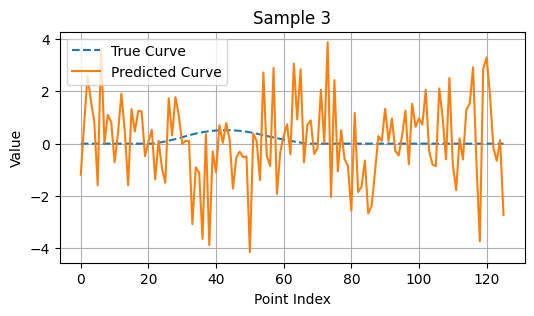

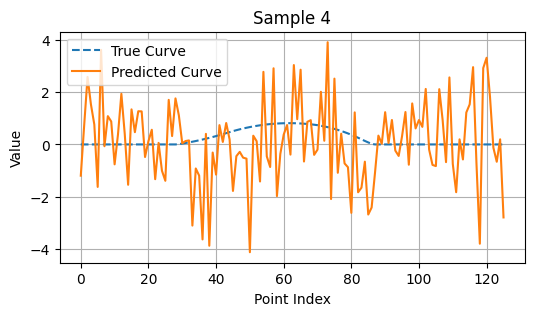

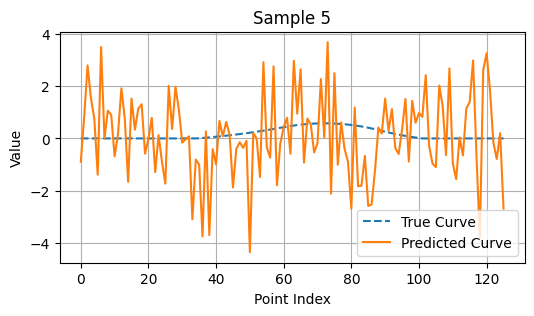

In [122]:
test_mse, r2, predictions, ground_truths = evaluate_model_r2(model, test_loader, device)
print(f"Test MSE: {test_mse:.4f}")
print(f"Test R²: {r2:.4f}")

# Plot the predicted vs ground truth curves
plot_predictions(predictions, ground_truths)

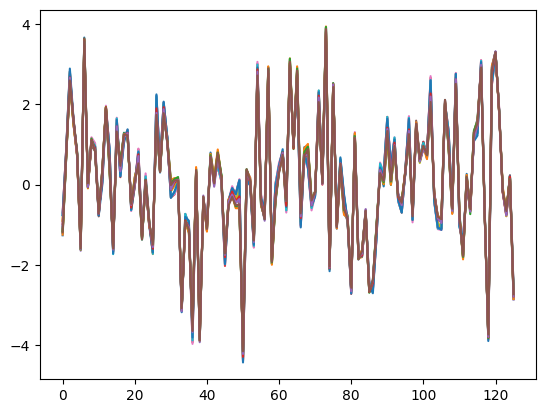

In [123]:
for i in range(len(predictions)):
    plt.plot(predictions[i])


Difference between video 0 and 1:
Mean difference: 0.1935
Max difference: 1.0000
% pixels different: 22.90%

Difference between video 0 and 2:
Mean difference: 0.1354
Max difference: 1.0000
% pixels different: 16.80%

Difference between video 1 and 2:
Mean difference: 0.0938
Max difference: 1.0000
% pixels different: 13.11%


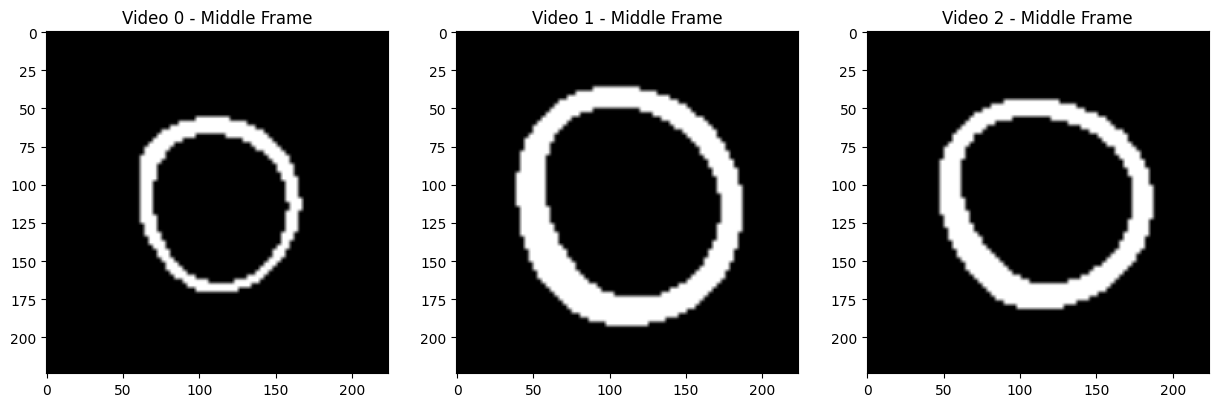

In [156]:
# Check frame-by-frame differences
def compare_videos(batch_videos):
    for i in range(3):  # Compare first 3 videos
        for j in range(i+1, 3):
            diff = (batch_videos[i] - batch_videos[j]).abs()
            print(f"\nDifference between video {i} and {j}:")
            print(f"Mean difference: {diff.mean():.4f}")
            print(f"Max difference: {diff.max():.4f}")
            print(f"% pixels different: {(diff > 0.1).float().mean()*100:.2f}%")

    # Visualize middle frame of each video
    plt.figure(figsize=(15, 5))
    for i in range(3):
        plt.subplot(1, 3, i+1)
        middle_frame = batch_videos[i, batch_videos.shape[1]//2].cpu()  # Get middle frame
        plt.imshow(middle_frame[0], cmap='gray')  # Assuming single channel
        plt.title(f'Video {i} - Middle Frame')
    plt.show()

compare_videos(batch_videos)

In [16]:
class VarianceTracker:
    def __init__(self, model):
        self.model = model
        self.hooks = []
        self.layer_stats = {}
        
    def hook_fn(self, name):
        def fn(module, input, output):
            if isinstance(output, torch.Tensor):
                # Reshape output to [batch_size, -1] to handle different layer shapes
                flat_output = output.view(output.size(0), -1)
                
                # Calculate variance between different samples in batch
                sample_means = flat_output.mean(dim=1)
                between_sample_var = sample_means.var()
                
                # Calculate average variance within samples
                within_sample_var = flat_output.var(dim=1).mean()
                
                self.layer_stats[name] = {
                    'between_sample_var': between_sample_var.item(),
                    'within_sample_var': within_sample_var.item(),
                    'shape': output.shape
                }
        return fn
    
    def register_hooks(self):
        # Clear any existing hooks
        self.remove_hooks()
        
        # Register new hooks
        for name, module in self.model.named_modules():
            if isinstance(module, (nn.Linear, nn.LayerNorm, nn.ReLU)):
                hook = module.register_forward_hook(self.hook_fn(name))
                self.hooks.append(hook)
    
    def remove_hooks(self):
        for hook in self.hooks:
            hook.remove()
        self.hooks = []
    
    def analyze_batch(self, batch):
        self.layer_stats = {}
        
        # Forward pass
        with torch.no_grad():
            output = self.model(batch)
        
        # Print statistics
        print("\nLayer Variance Analysis:")
        print("-" * 50)
        for name, stats in self.layer_stats.items():
            print(f"\nLayer: {name}")
            print(f"Shape: {stats['shape']}")
            print(f"Between-sample variance: {stats['between_sample_var']:.8f}")
            print(f"Within-sample variance: {stats['within_sample_var']:.8f}")
            if stats['between_sample_var'] > 0:
                ratio = stats['within_sample_var'] / stats['between_sample_var']
                print(f"Within/Between ratio: {ratio:.4f}")
        
        return output

# Usage example:
tracker = VarianceTracker(model)
tracker.register_hooks()

# Get a batch of videos
batch_videos, _ = next(iter(train_loader))
batch_videos = batch_videos.to(device)

# Analyze the batch
_ = tracker.analyze_batch(batch_videos)

# Clean up
tracker.remove_hooks()


Layer Variance Analysis:
--------------------------------------------------

Layer: patch_embed.norm
Shape: torch.Size([8, 13, 56, 56, 128])
Between-sample variance: 0.00000000
Within-sample variance: 0.04926629
Within/Between ratio: 150358239.1527

Layer: features.0.0.norm1
Shape: torch.Size([8, 13, 56, 56, 128])
Between-sample variance: 0.00000000
Within-sample variance: 0.03307639
Within/Between ratio: 132344268.0367

Layer: features.0.0.norm2
Shape: torch.Size([8, 13, 56, 56, 128])
Between-sample variance: 0.00000000
Within-sample variance: 0.80576730
Within/Between ratio: 721454558.4780

Layer: features.0.0.mlp.0
Shape: torch.Size([8, 13, 56, 56, 512])
Between-sample variance: 0.00000000
Within-sample variance: 0.10177027
Within/Between ratio: 1470698050516.2129

Layer: features.0.0.mlp.3
Shape: torch.Size([8, 13, 56, 56, 128])
Between-sample variance: 0.00000000
Within-sample variance: 0.04143303
Within/Between ratio: 71767363542675.2031

Layer: features.0.1.norm1
Shape: torch.S

In [36]:
class EarlyLayerTracker:
    def __init__(self, model):
        self.model = model
        self.hooks = []
        
    def hook_fn(self, name):
        def fn(module, input, output):
            if isinstance(output, torch.Tensor):
                # Get stats before any reshaping
                orig_shape = output.shape
                
                # For each sample in batch
                for i in range(min(3, output.size(0))):
                    print(f"\n{name} - Sample {i}")
                    sample = output[i]
                    print(f"Shape: {orig_shape}")
                    print(f"Mean: {sample.mean().item():.6f}")
                    print(f"Std: {sample.std().item():.6f}")
                    print(f"Max: {sample.max().item():.6f}")
                    print(f"Min: {sample.min().item():.6f}")
                
                # Between sample differences
                if output.size(0) > 1:
                    diff01 = (output[0] - output[1]).abs().mean().item()
                    diff12 = (output[1] - output[2]).abs().mean().item()
                    print(f"\nMean abs difference between samples:")
                    print(f"Sample 0-1: {diff01:.6f}")
                    print(f"Sample 1-2: {diff12:.6f}")
                
        return fn
    
    def register_hooks(self):
        # Clear existing hooks
        self.remove_hooks()
        
        # Register hooks for specific early layers
        tracked_layers = [
            'patch_embed',  # Initial embedding
            'pos_embed',    # Position embedding
            'pos_drop',     # Dropout after position embedding
            'features.0.0.norm1',  # First norm layer
            'features.0.0.attn',   # First attention layer
            'features.0.0.mlp.0'   # First MLP layer
        ]
        
        for name, module in self.model.named_modules():
            if any(layer in name for layer in tracked_layers):
                hook = module.register_forward_hook(self.hook_fn(name))
                self.hooks.append(hook)
    
    def remove_hooks(self):
        for hook in self.hooks:
            hook.remove()
        self.hooks = []

# Use the tracker
tracker = EarlyLayerTracker(model)
tracker.register_hooks()

# Get a batch and run it through
batch_videos, _ = next(iter(train_loader))
batch_videos = batch_videos.to(device)

with torch.no_grad():
    _ = model(batch_videos)

tracker.remove_hooks()


patch_embed.proj - Sample 0
Shape: torch.Size([8, 128, 13, 56, 56])
Mean: 0.016234
Std: 0.229024
Max: 1.143499
Min: -1.355213

patch_embed.proj - Sample 1
Shape: torch.Size([8, 128, 13, 56, 56])
Mean: 0.016533
Std: 0.229141
Max: 1.142245
Min: -1.355213

patch_embed.proj - Sample 2
Shape: torch.Size([8, 128, 13, 56, 56])
Mean: 0.017151
Std: 0.230639
Max: 1.143499
Min: -1.355213

Mean abs difference between samples:
Sample 0-1: 0.019320
Sample 1-2: 0.024227

patch_embed.norm - Sample 0
Shape: torch.Size([8, 13, 56, 56, 128])
Mean: -0.085904
Std: 0.390906
Max: 3.051787
Min: -3.343791

patch_embed.norm - Sample 1
Shape: torch.Size([8, 13, 56, 56, 128])
Mean: -0.086523
Std: 0.389206
Max: 3.049643
Min: -3.340447

patch_embed.norm - Sample 2
Shape: torch.Size([8, 13, 56, 56, 128])
Mean: -0.087648
Std: 0.391253
Max: 3.034456
Min: -3.342891

Mean abs difference between samples:
Sample 0-1: 0.040604
Sample 1-2: 0.049713

patch_embed - Sample 0
Shape: torch.Size([8, 13, 56, 56, 128])
Mean: -0.08